In [182]:
import os
import json
import math
import numpy as np
import pandas as pd
import random
from bokeh.io import output_file, show , output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource,  LabelSet
from bokeh.palettes import Viridis256,all_palettes,BrBG, PiYG, RdGy, RdYlGn, YlGnBu, PuBuGn, Colorblind, Bokeh,Category20,Accent
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter

import cv2
from PIL import Image
from tqdm.auto import tqdm, trange
import glob
import re
from pynvml import *
from datetime import datetime
from fancyimpute import IterativeImputer

import torchvision,torch
from torchvision.transforms.functional import to_tensor, to_pil_image
import torch.nn.functional as F
from torchvision import models
from torch import nn
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import class_weight
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

from torchsummary import summary
import adabound
import scikitplot as skplt

# Class Functions

In [183]:
def cudaalloc():
  nvmlInit()
  h = nvmlDeviceGetHandleByIndex(0)
  info = nvmlDeviceGetMemoryInfo(h)
  print(f'total    : {(info.total)/1000000000} GB')
  print(f'free     : {(info.free)/1000000000} GB')
  print(f'used     : {(info.used)/1000000000} GB')

In [184]:
def get_class_names(y_data):
    y_class_names = []
    for i in range(len(y_data)):
        if(y_data[i]==0):
            y_class_names.append("Alive")
        elif (y_data[i]==1):
            y_class_names.append("Dead")
    return y_class_names

In [185]:
def print_multi_confusion_matrix(actual_class, pred_class,target_names):
    df_array  = confusion_matrix(actual_class, pred_class)
    df_cm = pd.DataFrame(df_array, index = [i for i in ["T_" + x for x in target_names]],
                      columns = [i for i in ["P_" + x for x in target_names]])
    plt.figure(figsize = (7,7))
    plt.title("Confusion Matrix")
    plt.xlabel('Target Lvef')
    plt.ylabel('Predicted Lvef')
    sn.heatmap(df_cm, annot=True,fmt=".1f")
    sn.set(font_scale=1) 
    print(classification_report(actual_class , pred_class, target_names=target_names))

In [186]:
def get_auc_curve(y_test, probs):
    fpr, tpr, threshold = roc_curve(y_test, probs)
    return fpr,tpr,threshold

def plot_auc_curve(fpr,tpr,roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [187]:
def get_best_threshold(y_true, y_pred, thresholds):
    best_threshold = 0.5
    best_youden_index = 0
    for t in thresholds:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred > t).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        youden_index = sensitivity + specificity - 1
        if youden_index > best_youden_index:
            best_youden_index = youden_index
            best_threshold = t
    print(f"Best YD index : {best_youden_index } ")
    #print(f"best threshold : {best_threshold}")
    return best_threshold

In [188]:
class MortalityData(Dataset):
    
    def __init__(self, root_path , datadict, transform):
        self.path = root_path
        self.transform = transform
        self.ids = list(datadict.keys())
        self.features = list(datadict.values())
    
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        cropSize=(112,112)
        frames = np.array(self.get_frames_from_video(self.path + self.ids[idx]+".avi", 16))
        features = self.features[idx] 
        frames_tr = []
        if(len(frames)<16):
            print(self.ids[idx])
        for frame in frames:
            frame = self.transform(Image.fromarray(frame))
            frames_tr.append(frame)
            
        if len(frames_tr)>0:
            frames_tr = torch.stack(frames_tr)
        return frames_tr, features['label']
    
    
    def get_frames_from_video(self, filename, n_frames= 1):
        frames = []
        v_cap = cv2.VideoCapture(filename) #open the video file
        v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))  #passing the respective property name into the .get method of the video pointer will allow us to obtain the total number of frames in the video 
        frame_list= np.linspace(0, v_len-1, n_frames, dtype=np.int16)
        all_frames = []
        for fn in range(v_len):
            success, frame = v_cap.read() #reades every frame if the frames are over it will go to the next video
            if success is False:
                continue
            all_frames.append(frame)
            if (fn in frame_list):
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  
                frames.append(frame)
        v_cap.release()
        return frames

In [189]:
class MortalityNetVideoClass(nn.Module):
    def __init__(self,resnetmodel):
        super().__init__()

        self.features_conv = nn.Sequential(
            resnetmodel.stem,
            resnetmodel.layer1,
            resnetmodel.layer2,
            resnetmodel.layer3,
            resnetmodel.layer4,
        )
        self.averagepool = resnetmodel.avgpool
        self.fc3 = nn.Linear(512, 2)
        self.relu = nn.ReLU()
        self.video_features1 = 0
        self.video_features2 = 0
        #self.fc5 = nn.Linear(100, 2)  #lvef,lesv
        self.gradients = None
        self.base_gradients = None
    
    def activations_hook(self, grad):
        self.gradients = grad
 
    def forward(self, x1):
        
        x = self.features_conv(x1)
        if x.requires_grad:
            x.register_hook(self.activations_hook)
        
        x11 = self.averagepool(x)
        x11 = x11.flatten(1)
        x = self.fc3(x11)       
        return x
     
    def get_activations_gradient(self):
        return self.gradients
    
    def get_average_pool(self, x):
        return self.averagepool(self.features_conv(x))
    
    def get_activations(self, x):
        return self.features_conv(x)
    

In [190]:
def getitem(idx, data, transform,path):
    cropSize=(112,112)
    frames = np.array(get_frames_from_video(path + idx+".avi", 16))
    features = data
    frames_tr = []
    if(len(frames)<16):
        print(self.ids[idx])
    for frame in frames:
        frame = transform(Image.fromarray(frame))
        frames_tr.append(frame)
            
    if len(frames_tr)>0:
        frames_tr = torch.stack(frames_tr)
        
    return frames_tr, features['label']
    
    
def get_frames_from_video(filename, n_frames= 1):
    frames = []
    v_cap = cv2.VideoCapture(filename) #open the video file
    v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))  #passing the respective property name into the .get method of the video pointer will allow us to obtain the total number of frames in the video 
    frame_list= np.linspace(0, v_len-1, n_frames, dtype=np.int16)
    all_frames = []
    for fn in range(v_len):
        success, frame = v_cap.read() #reades every frame if the frames are over it will go to the next video
        if success is False:
            continue
        all_frames.append(frame)
        if (fn in frame_list):
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  
            frames.append(frame)
    v_cap.release()
    return frames

In [191]:
def get_Alberta_Test_List(Dataframe):
    Dataframe = Dataframe.rename(columns={"StudyNumber":"PatientID", "PLAX_video_path":"PLAX_video_id"})
    Dataframe = Dataframe.drop(['Unnamed: 0','Obs'],axis=1)
    Dataframe = Dataframe.sample(frac = 1, random_state=42)
    Dataframe = Dataframe.drop_duplicates(subset='PatientID', keep="last").reset_index()
    
    gender = []
    for i in range(len(Dataframe)):
        if(Dataframe['Gender'][i]=='Male' or Dataframe['Gender'][i]==1):
            gender.append(1)
        else:
            gender.append(0)
    Dataframe['Gender'] = gender

    columns = Dataframe.drop(['PatientID','fileID','EventName', 'visit_date','death_date','days_to_event', 'days_to_event(all)',
                          'A4C_video_path','PLAX_video_id','mortality'], axis = 1).columns
    features = columns

    for col in features:
        Dataframe[col] = pd.to_numeric(Dataframe[col],errors='coerce')

    Dataframe = Dataframe.replace(r'^\s*$', np.nan, regex=True)
    X_data = Dataframe[features].values
    y_data = Dataframe[['mortality']].values
    
    testlist = {}
    h, w = 112, 112
    transformer = transforms.Compose([
        transforms.Resize((h,w)),
        transforms.ToTensor()
    ])
    batch_size = 8
    for i in range(len(Dataframe)):
        testlist[Dataframe["fileID"][i] + "/" + Dataframe["PLAX_video_id"][i]] = {}
        testlist[Dataframe["fileID"][i] + "/" + Dataframe["PLAX_video_id"][i]]["label"] = Dataframe.iloc[i]["mortality"]
        testlist[Dataframe["fileID"][i] + "/" + Dataframe["PLAX_video_id"][i]]["features"] = X_data[i]
    
    path = "../AlbertaHeart/video/"
    return testlist

In [192]:
def get_cuttoff_from_Mackay(model,days):
    Dataframe = pd.read_csv('Generated_csv_files/Mackay_mortality_within_' + str(days) +'_days.csv')
    Dataframe = Dataframe.drop(['Unnamed: 0'],axis=1)
    Dataframe = Dataframe.sample(frac = 1, random_state=42)
    Dataframe = Dataframe.drop_duplicates(subset='PatientID', keep="last").reset_index()
    Dataframe = Dataframe.sort_values(by=['PatientID','ExamDate']).reset_index(drop=True)

    gender = []
    for i in range(len(Dataframe)):
        if(Dataframe['gender'][i]=='Male' or Dataframe['gender'][i]==1):
            gender.append(1)
        else:
            gender.append(0)
    Dataframe['gender'] = gender

    columns = Dataframe.drop(['PatientID','Mortality_Date', 'CV_death', 'ExamDate', 'A4C_video_id','PLAX_video_id', 'visit_duration', 'visits', 'death_days',
           'mortality'], axis = 1).columns
    features = columns

    for col in features:
        Dataframe[col] = pd.to_numeric(Dataframe[col],errors='coerce')

    Dataframe = Dataframe.replace(r'^\s*$', np.nan, regex=True)
    X_data = Dataframe[features]
    y_data = Dataframe[['mortality']]
    
    testlist = {}
    h, w = 112, 112
    transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.ToTensor()
            ])
    batch_size = 8
    for i in range(len(Dataframe)):
        testlist[str(Dataframe["PatientID"][i])+"/"+ Dataframe["PLAX_video_id"][i]] = {}
        testlist[str(Dataframe["PatientID"][i])+"/"+ Dataframe["PLAX_video_id"][i]]["label"] =  Dataframe.iloc[i]["mortality"]
    
    all_video_data = list(testlist.keys())
    print("total views in Mackay data list is " , len(all_video_data))
    
    ground_truth = []
    all_probs = []
    count=0
    softmax = nn.Softmax(dim=0)
    model.eval()
    with torch.no_grad():
        for i in tqdm(range(len(all_video_data))):
            data , label = getitem(all_video_data[i],testlist[all_video_data[i]],transformer,path = "video/")

            data_tensor = data.unsqueeze(0)
            frames_tensor = torch.transpose(data_tensor, 2, 1)
            
            output = model(frames_tensor.to(device))
            pred_prob = np.array(softmax(output[0]).cpu())
        
            ground_truth.append(label)
            all_probs.append(pred_prob)
            
    class_names=["Alive","Dead"]
    y_test_class_names = get_class_names(ground_truth)
    y_test_class = label_binarize(np.array(y_test_class_names),classes=class_names)
    
    pred_prob_all = np.array(all_probs)
    y_test_class = np.array(y_test_class)
    fpr, tpr,t = get_auc_curve(y_test_class,pred_prob_all[:, 1])
    roc_auc = auc(fpr, tpr)
    
    #tprs_extended_roc.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    
    youden_index  = tpr + (1-fpr) - 1
    ix_roc = np.argmax(youden_index)
    
    cutoff_roc = t[ix_roc]
    print("cutoff in Mackay data roc is ", cutoff_roc)
    optimal_points_roc = fpr[ix_roc],tpr[ix_roc]
    
    precision, recall, thresholds = precision_recall_curve(y_test_class,pred_prob_all[:, 1])
    #precision_extended.append(np.interp(mean_recall, 1 - recall, precision))
    auc_score_pr = auc(recall, precision)
    
    fscore = (2 * precision * recall) / (precision + recall)
    fscore = np.nan_to_num(fscore) 
    ix_pr = np.argmax(fscore)

    cutoff_pr = thresholds[ix_pr]
    print("cutoff in Mackay data pr is ", cutoff_pr)
    optimal_points_pr = [recall[ix_pr],precision[ix_pr]]
    
    return cutoff_roc,cutoff_pr

# Getting the prediction values for DL

In [86]:
root = "../AlbertaHeart/"
Dataframe = pd.read_csv(root + 'Generated_csv_files/Alberta_mortality_1825_days.csv')
Dataframe = Dataframe.rename(columns={"StudyNumber":"PatientID", "PLAX_video_path":"PLAX_video_id"})
Dataframe = Dataframe.drop(['Unnamed: 0','Obs'],axis=1)
Dataframe = Dataframe.sample(frac = 1, random_state=42)
Dataframe = Dataframe.drop_duplicates(subset='PatientID', keep="last").reset_index()

In [87]:
len(Dataframe.loc[Dataframe['mortality']==0]),len(Dataframe.loc[Dataframe['mortality']==1])

(477, 111)

In [88]:
gender = []
for i in range(len(Dataframe)):
    if(Dataframe['Gender'][i]=='Male' or Dataframe['Gender'][i]==1):
        gender.append(1)
    else:
        gender.append(0)
Dataframe['Gender'] = gender

columns = Dataframe.drop(['PatientID','fileID','EventName', 'visit_date','death_date','days_to_event', 'days_to_event(all)',
                          'A4C_video_path','PLAX_video_id','mortality'], axis = 1).columns
features = columns

for col in features:
    Dataframe[col] = pd.to_numeric(Dataframe[col],errors='coerce')

Dataframe = Dataframe.replace(r'^\s*$', np.nan, regex=True)
X_data = Dataframe[features].values
y_data = Dataframe[['mortality']].values

In [89]:
len(Dataframe),len(Dataframe['PatientID'].unique())

(588, 588)

In [90]:
len(Dataframe.loc[Dataframe['mortality']==1]['PatientID'].unique()) , len(Dataframe.loc[Dataframe['mortality']==0]),

(111, 477)

In [91]:
def collate_fn_r3d_18(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    
    imgs_tensor = torch.stack(imgs_batch)
    imgs_tensor = torch.transpose(imgs_tensor, 2, 1) #[1, 16, 3, 224, 224] - >  [1, 3, 16, 224, 224]
    labels_tensor = torch.stack(label_batch)

    return imgs_tensor, labels_tensor

In [92]:
testlist = {}
h, w = 112, 112
transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.ToTensor()
            ])
batch_size = 8
for i in range(len(Dataframe)):
    testlist[Dataframe["fileID"][i] + "/" + Dataframe["PLAX_video_id"][i]] = {}
    testlist[Dataframe["fileID"][i] + "/" + Dataframe["PLAX_video_id"][i]]["label"] = Dataframe.iloc[i]["mortality"]
    testlist[Dataframe["fileID"][i] + "/" + Dataframe["PLAX_video_id"][i]]["features"] = X_data[i]
path = "../AlbertaHeart/video/"
test_ds =  MortalityData(path, datadict = testlist, transform= transformer)
print(len(test_ds))
test_dl = DataLoader(test_ds, batch_size= batch_size, shuffle=False, collate_fn= collate_fn_r3d_18)
for xb, yb in test_dl:
    print(xb.shape, yb.shape)
    break

588
torch.Size([8, 3, 16, 112, 112]) torch.Size([8])


In [93]:
resnetmodel = models.video.r2plus1d_18(pretrained=True, progress=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnetmodel = resnetmodel.to(device)
model = MortalityNetVideoClass(resnetmodel)
model = model.to(device)

In [94]:
path2models = "models/"
#Mackay_3_class_fold_10_weights.pt
model.load_state_dict(torch.load(path2models + "Mackay_mortality_1825days_External_weights.pt",map_location=torch.device('cpu')))

<All keys matched successfully>

In [95]:
all_video_data = list(testlist.keys())
print(len(all_video_data))

588


In [98]:
quality_of_life_list = {}
count=0
softmax = nn.Softmax(dim=0)
path = '../AlbertaHeart/video/'
model.eval()
with torch.no_grad():
    for i in tqdm(range(len(all_video_data))):
        data , label = getitem(all_video_data[i],testlist[all_video_data[i]], transformer, path)

        data_tensor = data.unsqueeze(0)
        frames_tensor = torch.transpose(data_tensor, 2, 1)
            
        output = model(frames_tensor.to(device))
        pred_prob = np.array(softmax(output[0]).cpu())
        quality_of_life_list[all_video_data[i][:7]] = {}
        quality_of_life_list[all_video_data[i][:7]]["class_0_prob"] = pred_prob[0]
        quality_of_life_list[all_video_data[i][:7]]["class_1_prob"] = pred_prob[1]
        quality_of_life_list[all_video_data[i][:7]]["ground_truth"] = label

  0%|          | 0/588 [00:00<?, ?it/s]

In [99]:
details = {
    'PatientID' : list(quality_of_life_list.keys()),
    'class_0_prob': [list(quality_of_life_list.values())[i]['class_0_prob'] for i in range(len(list(quality_of_life_list.values())))],
    'class_1_prob' : [list(quality_of_life_list.values())[i]['class_1_prob'] for i in range(len(list(quality_of_life_list.values())))],
    'ground_truth' : [list(quality_of_life_list.values())[i]['ground_truth'] for i in range(len(list(quality_of_life_list.values())))]
}

In [100]:
df = pd.DataFrame(details)

In [109]:
df.to_csv('5_year_mortality_probability.csv')

# Getting the prediction values for CatBoost

In [167]:
columns_to_train = ['Ivs',
                    'Lvpw',
                    'Lvidd',
                    'Lvids',
                    'Lvedv',
                    'Lvesv',
                    'Hr',
                    'Dt',
                    'Ivrt',
                    'E',
                    'A',
                    'TDI_e_lateral',
                    'TDI_e_septal',
                    'gender',
                    'age',
                    'LA_MAX_VOLUME',
                    'TR_VELOCITY',
                    'Ef']
get_features = columns_to_train

In [168]:
root = "../AlbertaHeart/"
External_Dataframe = pd.read_csv(root + 'Generated_csv_files/Alberta_mortality_1095_days.csv')
External_Dataframe = External_Dataframe.rename(columns={"StudyNumber":"PatientID", "PLAX_video_path":"PLAX_video_id"})
External_Dataframe = External_Dataframe.drop(['Unnamed: 0','Obs'],axis=1)
External_Dataframe = External_Dataframe.sample(frac = 1, random_state=42)
External_Dataframe = External_Dataframe.drop_duplicates(subset='PatientID', keep="last").reset_index()
External_Dataframe['IVSdcm'] = External_Dataframe['IVSdcm']*10
External_Dataframe['LVPWdcm'] = External_Dataframe['LVPWdcm']*10
External_Dataframe['LVIDdcm'] = External_Dataframe['LVIDdcm']*10
External_Dataframe = External_Dataframe.rename(columns=
                          {"IVSdcm": "Ivs", 
                           "LVPWdcm": "Lvpw",
                          "LVIDdcm":"Lvidd",
                          "LVIDscm":"Lvids",
                          "LVEDV MOD Bip (mL)":"Lvedv",
                          "LVESV MOD Bip (mL)":"Lvesv",
                          "heart_rate":"Hr",
                          "Decelerationms":"Dt",
                          "IVRTms":"Ivrt",
                          "MV-E (cm/sec)":"E",
                          "MV-A (cm/sec)":"A",
                          "PWTDI e\' lateral":"TDI_e_lateral",
                          "PWTDI e\' septal":"TDI_e_septal",
                           "Gender":"gender",
                          "AgeatEnrollment":"age",
                           "LVEF":"Ef",
                          "LAVolume2Dml":"LA_MAX_VOLUME",
                          "TrVmax m/sec":"TR_VELOCITY"})
features = columns_to_train

for col in columns_to_train:
    if(col=='gender'):
        continue
    External_Dataframe[col] = pd.to_numeric(External_Dataframe[col],errors='coerce')

External_Dataframe = External_Dataframe.replace(r'^\s*$', np.nan, regex=True)

In [169]:
len(External_Dataframe.loc[External_Dataframe['mortality']==1]['PatientID']) , len(External_Dataframe.loc[External_Dataframe['mortality']==0])

(61, 534)

In [170]:
X_test = External_Dataframe[get_features].values
y_test = External_Dataframe['mortality'].values

In [171]:
from catboost import Pool, CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

In [172]:
model = CatBoostClassifier()
model.load_model("models/catboost/Mackay_1095days_External_Catboost.cbm")

In [173]:
all_video_data = External_Dataframe['PatientID'].values

In [174]:
print(len(all_video_data))

595


In [176]:
quality_of_life_list = {}
count=0
for i in tqdm(range(len(all_video_data))):
        quality_of_life_list[all_video_data[i]] = {}
        quality_of_life_list[all_video_data[i]]["class_0_prob"] = model.predict_proba(X_test[i])[0]
        quality_of_life_list[all_video_data[i]]["class_1_prob"] = model.predict_proba(X_test[i])[1]
        quality_of_life_list[all_video_data[i]]["ground_truth"] = y_test[i]

  0%|          | 0/595 [00:00<?, ?it/s]

In [177]:
details = {
    'PatientID' : list(quality_of_life_list.keys()),
    'class_0_prob': [list(quality_of_life_list.values())[i]['class_0_prob'] for i in range(len(list(quality_of_life_list.values())))],
    'class_1_prob' : [list(quality_of_life_list.values())[i]['class_1_prob'] for i in range(len(list(quality_of_life_list.values())))],
    'ground_truth' : [list(quality_of_life_list.values())[i]['ground_truth'] for i in range(len(list(quality_of_life_list.values())))]
}

In [178]:
df = pd.DataFrame(details)

In [180]:
df.to_csv('3_year_mortality_probability_catboost.csv')

# ROC curves and the PRC curves

In [194]:
tprs_extended_roc = []
mean_fpr = np.linspace(0,1,100)
optimal_points_roc = []
scores_roc = []

precision_extended = []
mean_recall = np.linspace(0,1,100)
optimal_points_pr = []
scores_pr = []

softmax = nn.Softmax(dim=0)
testlist = {}
h, w = 112, 112
transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.ToTensor()
            ])
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

for days in [365,1095,1825]:
    
    root = "../AlbertaHeart/"
    Alberta_df = pd.read_csv(root + 'Generated_csv_files/Alberta_mortality_' + str(days) + '_days.csv')
    Alberta_test_list = get_Alberta_Test_List(Alberta_df)
    
    resnetmodel = models.video.r2plus1d_18(pretrained=True, progress=False)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    resnetmodel = resnetmodel.to(device)
    model = MortalityNetVideoClass(resnetmodel)
    model = model.to(device)
    
    path2models = "models/"
    model.load_state_dict(torch.load(path2models + "Mackay_mortality_" + str(days) + "days_External_weights.pt",map_location=torch.device('cpu')))
    
    all_video_data = list(Alberta_test_list.keys())
    print("total views is " , len(all_video_data))
    
    ground_truth = []
    all_probs = []
    count=0
    softmax = nn.Softmax(dim=0)
    model.eval()
    with torch.no_grad():
        for i in tqdm(range(len(all_video_data))):
            data , label = getitem(all_video_data[i],Alberta_test_list[all_video_data[i]],transformer,path = "../AlbertaHeart/video/")

            data_tensor = data.unsqueeze(0)
            frames_tensor = torch.transpose(data_tensor, 2, 1)
            
            output = model(frames_tensor.to(device))
            pred_prob = np.array(softmax(output[0]).cpu())
        
            ground_truth.append(label)
            all_probs.append(pred_prob)
        
    class_names=["Alive","Dead"]
    y_test_class_names = get_class_names(ground_truth)
    y_test_class = label_binarize(np.array(y_test_class_names),classes=class_names)
    
    pred_prob_all = np.array(all_probs)
    y_test_class = np.array(y_test_class)
    fpr, tpr,t = get_auc_curve(y_test_class,pred_prob_all[:, 1])
    roc_auc = auc(fpr, tpr)
    
    tprs_extended_roc.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    scores_roc.append(roc_auc)
    print("auc score for roc is", roc_auc)
    
    youden_index  = tpr + (1-fpr) - 1
    ix_roc = np.argmax(youden_index)
    
    cutoff_roc = t[ix_roc]
    #optimal_points_roc.append([fpr[ix_roc],tpr[ix_roc]])
    print("the best cutoff for roc from Alberta Dataset is is", cutoff_roc)
    
    print("*"*20)
    
    precision, recall, thresholds = precision_recall_curve(y_test_class,pred_prob_all[:, 1])
    precision_extended.append(np.interp(mean_recall, 1 - recall, precision))
    auc_score_pr = auc(recall, precision)
    scores_pr.append(auc_score_pr)
    print("auc score for pr from Alberta Dataset is", auc_score_pr)
    
    fscore = (2 * precision * recall) / (precision + recall)
    fscore = np.nan_to_num(fscore) 
    ix_pr = np.argmax(fscore)
    
    cutoff_pr = thresholds[ix_pr]
    #optimal_points_pr.append([recall[ix_pr],precision[ix_pr]])
    print("the best cutoff for pr from Alberta Dataset is", cutoff_pr)
    
    M_cutoff_roc, M_cutoff_pr = get_cuttoff_from_Mackay(model, days)
    M_ix_roc = find_nearest(t,M_cutoff_roc)
    M_ix_pr = find_nearest(thresholds,M_cutoff_pr)
    print("nearest thresholds in Alberta for roc and pr is " , t[M_ix_roc],thresholds[M_ix_pr])
    optimal_points_pr.append([recall[M_ix_pr],precision[M_ix_pr]])
    optimal_points_roc.append([fpr[M_ix_roc],tpr[M_ix_roc]])
    print("*"*40)

total views is  595


  0%|          | 0/595 [00:00<?, ?it/s]

auc score for roc is 0.8188908145580589
the best cutoff for roc from Alberta Dataset is is 0.26290044
********************
auc score for pr from Alberta Dataset is 0.1251724071362669
the best cutoff for pr from Alberta Dataset is 0.62699604


/tmp/ipykernel_299908/2100353928.py:88: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


total views in Mackay data list is  3626


  0%|          | 0/3626 [00:00<?, ?it/s]

cutoff in Mackay data roc is  0.55166847
cutoff in Mackay data pr is  0.659837
nearest thresholds in Alberta for roc and pr is  0.54546446 0.6534528
****************************************


/tmp/ipykernel_299908/1185338655.py:82: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


total views is  595


  0%|          | 0/595 [00:00<?, ?it/s]

auc score for roc is 0.8196107324860318
the best cutoff for roc from Alberta Dataset is is 0.4549654
********************
auc score for pr from Alberta Dataset is 0.31677380727024773
the best cutoff for pr from Alberta Dataset is 0.7874411
total views in Mackay data list is  2937


  0%|          | 0/2937 [00:00<?, ?it/s]

cutoff in Mackay data roc is  0.5568635
cutoff in Mackay data pr is  0.64748424
nearest thresholds in Alberta for roc and pr is  0.5651773 0.64924943
****************************************
total views is  588


  0%|          | 0/588 [00:00<?, ?it/s]

auc score for roc is 0.7766445690973992
the best cutoff for roc from Alberta Dataset is is 0.3162788
********************
auc score for pr from Alberta Dataset is 0.4308922988634016
the best cutoff for pr from Alberta Dataset is 0.37652382
total views in Mackay data list is  2252


  0%|          | 0/2252 [00:00<?, ?it/s]

cutoff in Mackay data roc is  0.3520642
cutoff in Mackay data pr is  0.4557799
nearest thresholds in Alberta for roc and pr is  0.35419652 0.45395777
****************************************


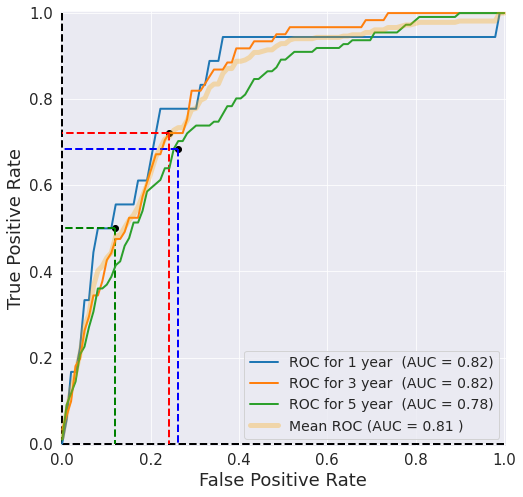

In [195]:
fig1 = plt.figure(figsize=[8,8])
sns.set_style("darkgrid")
colors = ['green','red','blue']
years = ['1 year','3 year','5 year']
plt.plot([0, 0], [1, 0], '--', lw=2,color='black')
plt.plot([1, 0], [0, 0], '--', lw=2,color='black')
for i in range(3):
    
    plt.plot(mean_fpr, tprs_extended_roc[i], lw=2, alpha=1, label='ROC for %s  (AUC = %0.2f)' % (years[i] , scores_roc[i]))
    plt.plot([optimal_points_roc[i][0], optimal_points_roc[i][0]], [optimal_points_roc[i][1], 0], '--', lw=2,color=colors[i])
    plt.plot([optimal_points_roc[i][0], 0], [optimal_points_roc[i][1], optimal_points_roc[i][1]], '--', lw=2,color=colors[i])
    plt.scatter(optimal_points_roc[i][0], optimal_points_roc[i][1], marker='o', color='black')
mean_tpr = np.mean(tprs_extended_roc, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='orange',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=5, alpha=0.3)
#plt.axhline(y = 0.5, color = 'r', linestyle = '--')

# draw vertical line from (0.7207,0.28) to (0.7207, 0)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
#plt.title('ROC curve of 1year, 3 years and 5 years Mortality')
plt.legend(loc="lower right", prop={'size': 14})
plt.xlim([-0.005, 1.005])
plt.ylim([-0.005, 1.005])
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.savefig('roc.png', bbox_inches='tight',pad_inches = 0)
plt.show()

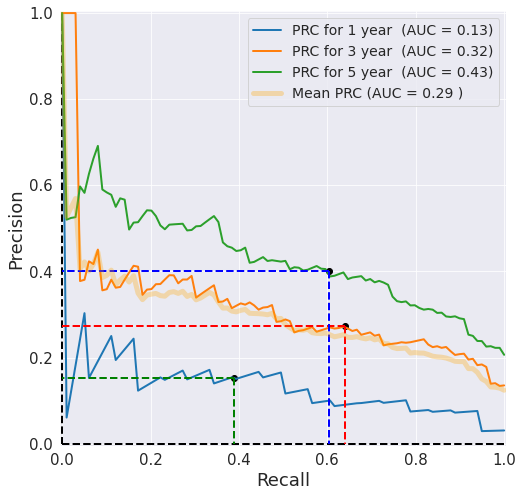

In [196]:
fig1 = plt.figure(figsize=[8,8])
sns.set_style("darkgrid")
colors = ['green','red','blue']
years = ['1 year','3 year','5 year']
plt.plot([0, 0], [1, 0], '--', lw=2,color='black')
plt.plot([1, 0], [0, 0], '--', lw=2,color='black')
for i in range(3):
    plt.plot(np.linspace(1,0,100), precision_extended[i], lw=2, alpha=1, label='PRC for %s  (AUC = %0.2f)' % (years[i] , scores_pr[i]))
    plt.plot([optimal_points_pr[i][0], optimal_points_pr[i][0]], [optimal_points_pr[i][1], 0], '--', lw=2,color=colors[i])
    plt.plot([optimal_points_pr[i][0], 0], [optimal_points_pr[i][1], optimal_points_pr[i][1]], '--', lw=2,color=colors[i])
    plt.scatter(optimal_points_pr[i][0], optimal_points_pr[i][1], marker='o', color='black')

mean_precision = np.mean(precision_extended, axis=0)
mean_auc = auc(np.linspace(1,0,100), mean_precision)
plt.plot(np.linspace(1,0,100),mean_precision, color='orange',
         label=r'Mean PRC (AUC = %0.2f )' % (mean_auc),lw=5, alpha=0.3)
#plt.axhline(y = 0.5, color = 'r', linestyle = '--')

# draw vertical line from (0.7207,0.28) to (0.7207, 0)
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
#plt.title('PR curve of 1year, 3 years and 5 years Mortality')
plt.legend(loc="upper right", prop={'size': 14})
plt.xlim([-0.005, 1.005])
plt.ylim([-0.005, 1.005])
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.savefig('pr.png', bbox_inches='tight',pad_inches = 0)

plt.show()

In [197]:
dataset = pd.read_csv("../AlbertaHeart/Generated_csv_files/AlbertaData_Mortality_PLAX.csv")
death_pid = list(dataset.loc[dataset['days_to_event'].isnull()]['StudyNumber'].unique())
data_death_pid  = dataset[dataset['StudyNumber'].isin(death_pid)]
data_death_pid = data_death_pid.drop_duplicates(subset='StudyNumber', keep="last").reset_index()
dataset = dataset[~dataset['StudyNumber'].isin(death_pid)]
frames = [dataset, data_death_pid]
result = pd.concat(frames,sort=False)

In [198]:
columns = ["StudyNumber", "days_to_event","days_to_event(all)"]
df = result[columns]
df = df.sample(frac = 1, random_state=42)
df = df.drop_duplicates(subset='StudyNumber', keep="last").reset_index()

In [199]:
len(df)

595

In [200]:
not_censored = []
for i in range(len(df)):
    if((df['days_to_event(all)'][i]<365 and df.loc[i].isnull()['days_to_event'])):
        not_censored.append(0)
    else:
        not_censored.append(1)


In [201]:
df["final_event"] = not_censored

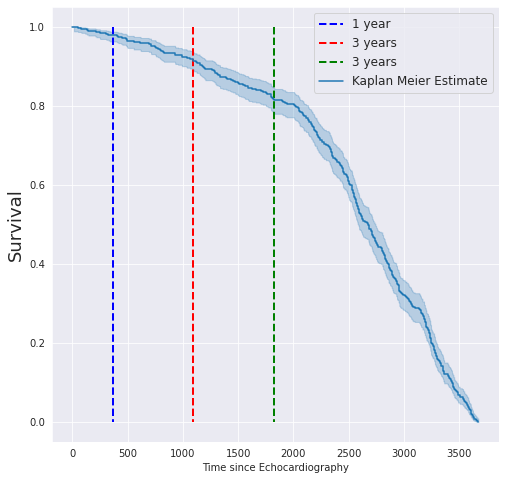

In [204]:
from lifelines import KaplanMeierFitter

plt.figure(figsize=[8,8])
durations = df['days_to_event(all)'] ## Time to event data of censored and event data
event_observed = df['final_event']  ## It has the churned (1) and censored is (0)

## create a kmf object as km
km = KaplanMeierFitter() ## instantiate the class to create an object
plt.plot([365, 365], [1, 0], '--', lw=2,color='blue',label='1 year')
plt.plot([1095, 1095], [1, 0], '--', lw=2,color='red',label='3 years')
plt.plot([1825, 1825], [1, 0], '--', lw=2,color='green',label='3 years')
## Fit the data into the model
km.fit(durations, event_observed,label='Kaplan Meier Estimate')
#plt.title("Kaplan Meier estimates of the Alberta Dataset")
plt.xlabel("Days after last event")
## Create an estimate
ax = km.plot()
ax.set_ylabel("Survival", fontsize=18)
ax.set_xlabel("Time since Echocardiography")
ax.axis('tight')
plt.legend(loc="upper right", prop={'size': 12})

In [205]:
dataset = pd.read_csv("../AlbertaHeart/Generated_csv_files/AlbertaData_Mortality_PLAX.csv")
columns = ["StudyNumber", "EventName", "days_to_event","days_to_event(all)"]
df_Alberta = dataset[columns]
df_Alberta = df.drop_duplicates(subset='StudyNumber', keep="first").reset_index()

In [206]:
not_censored = []
for i in range(len(df)):
    if((df.loc[i].isnull()['days_to_event'])):
        not_censored.append(0)
    else:
        not_censored.append(1)
df_Alberta['final_event'] = not_censored

In [207]:
df_Alberta.head()

,level_0,index,StudyNumber,days_to_event,days_to_event(all),final_event
0,0,59,DA0100,NaN,3309,0
1,1,24,DA0045,NaN,3547,0
2,2,383,DB0211,NaN,2568,0
3,3,166,DA0259,NaN,2763,0
4,4,346,DB0160,NaN,2856,0


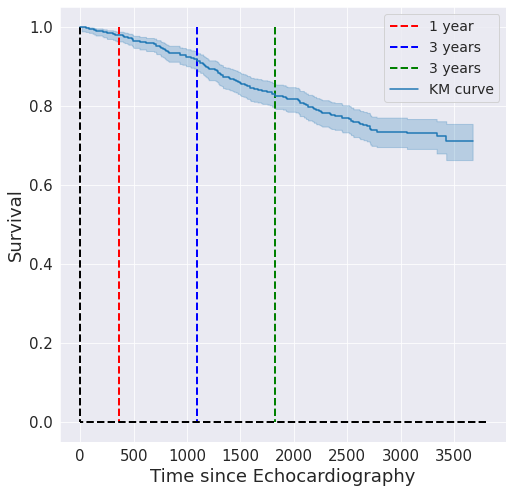

In [208]:
plt.figure(figsize=[8,8])
durations = df_Alberta['days_to_event(all)'] ## Time to event data of censored and event data
event_observed = df_Alberta['final_event']  ## It has the churned (1) and censored is (0)
sns.set_style("darkgrid")
## create a kmf object as km
km = KaplanMeierFitter() ## instantiate the class to create an object


plt.plot([365, 365], [1, 0], '--', lw=2,color='red',label='1 year')
plt.plot([1095, 1095], [1, 0], '--', lw=2,color='blue',label='3 years')
plt.plot([1825, 1825], [1, 0], '--', lw=2,color='green',label='3 years')
plt.plot([3800, 0], [0, 0], '--', lw=2,color='black')
plt.plot([0, 0], [1, 0], '--', lw=2,color='black')
## Fit the data into the model
km.fit(durations, event_observed,label='KM curve')
#plt.title("Kaplan Meier estimates of the Alberta Dataset")
plt.xlabel("Days after last event")
## Create an estimate
ax = km.plot()
ax.set_ylabel("Survival", fontsize=18)
ax.set_xlabel("Time since Echocardiography", fontsize=18)
ax.axis('tight')
plt.legend(loc="best", prop={'size': 14})
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
ax.get_figure().savefig("km.png",bbox_inches='tight',pad_inches = 0)

In [209]:
dataset = pd.read_csv("../AlbertaHeart/Generated_csv_files/AlbertaData_Mortality_PLAX.csv")
columns = ["StudyNumber", "EventName", "days_to_event","days_to_event(all)"]
df_Alberta = dataset[columns]
df_Alberta = df.drop_duplicates(subset='StudyNumber', keep="first").reset_index()

In [210]:
not_censored = []
for i in range(len(df_Alberta)):
    if((df_Alberta.loc[i].isnull()['days_to_event'])):
        not_censored.append(0)
    else:
        not_censored.append(1)
df_Alberta['final_event'] = not_censored

In [211]:
dataset2 = pd.read_csv("Generated_csv_files/Mackay_mortality_all_PLAX.csv")
dataset2 = dataset2.loc[~((dataset2['days_alive']<=0) & (dataset2['death_days'].isnull()))]
dataset2 = dataset2.sort_values(by=['PatientID','ExamDate']).reset_index(drop=True)
dataset2 = dataset2.drop_duplicates(subset='PatientID', keep="first").reset_index()

In [212]:
not_censored = []
for i in range(len(dataset2)):
    if((dataset2.loc[i].isnull()['death_days'])):
        not_censored.append(0)
    else:
        not_censored.append(1)
dataset2['final_event'] = not_censored

In [213]:
len(dataset2) , len(df_Alberta)

(3925, 595)

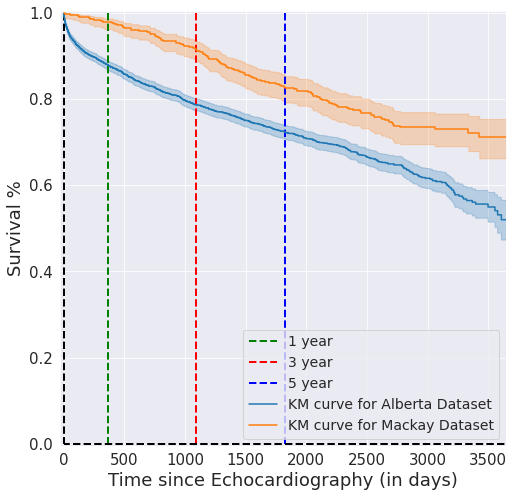

In [236]:
plt.figure(figsize=[8,8])
durations1 = df_Alberta['days_to_event(all)'] ## Time to event data of censored and event data
event_observed1 = df_Alberta['final_event']  ## It has the churned (1) and censored is (0)

durations2 = dataset2['days_alive'] ## Time to event data of censored and event data
event_observed2 = dataset2['final_event']  ## It has the churned (1) and censored is (0)

sns.set_style("darkgrid")
## create a kmf object as km
km = KaplanMeierFitter() ## instantiate the class to create an object

plt.xlim([0, 3650])
plt.plot([365, 365], [1, 0], '--', lw=2,color='green',label='1 year')
plt.plot([1095, 1095], [1, 0], '--', lw=2,color='red',label='3 year')
plt.plot([1825, 1825], [1, 0], '--', lw=2,color='blue',label='5 year')
plt.plot([4500, 0], [0, 0], '--', lw=2,color='black')
plt.plot([0, 0], [1, 0], '--', lw=2,color='black')
## Fit the data into the model
km.fit(durations2, event_observed2,label='KM curve for Alberta Dataset')
#plt.title("Kaplan Meier estimates of the Alberta Dataset")
plt.xlabel("Days after last event")
## Create an estimate
ax = km.plot()


km1 = KaplanMeierFitter()
km1.fit(durations1, event_observed1,label='KM curve for Mackay Dataset')
ax = km1.plot(ax=ax)
ax.set_ylabel("Survival %", fontsize=18)
ax.set_xlabel("Time since Echocardiography (in days)", fontsize=18)
ax.axis('tight')
plt.legend(loc="best", prop={'size': 14})
plt.xlim([-30, 3650])
plt.ylim([-0.005, 1.005])
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
ax.get_figure().savefig("km.png",bbox_inches='tight',pad_inches = 0)

# Calibration Bar Graphs

In [283]:
data_DL = pd.read_csv('Generated_csv_files/DL_' + str(time) +'.csv')
data_Cat = pd.read_csv('Generated_csv_files/Cat_' + str(time) +'.csv')

In [229]:
time = 365
data_DL_1_year = pd.read_csv('Generated_csv_files/DL_' + str(time) +'.csv')
data_Cat_1_year = pd.read_csv('Generated_csv_files/Cat_' + str(time) +'.csv')

time = 1095
data_DL_3_year = pd.read_csv('Generated_csv_files/DL_' + str(time) +'.csv')
data_Cat_3_year = pd.read_csv('Generated_csv_files/Cat_' + str(time) +'.csv')

time = 1825
data_DL_5_year = pd.read_csv('Generated_csv_files/DL_' + str(time) +'.csv')
data_Cat_5_year = pd.read_csv('Generated_csv_files/Cat_' + str(time) +'.csv')

In [230]:
number_of_encounters_DL_1_year = []
percentage_of_truth_DL_1_year = []
number_of_encounters_Cat_1_year = []
percentage_of_truth_Cat_1_year = []

number_of_encounters_DL_3_year = []
percentage_of_truth_DL_3_year = []
number_of_encounters_Cat_3_year = []
percentage_of_truth_Cat_3_year = []

number_of_encounters_DL_5_year = []
percentage_of_truth_DL_5_year = []
number_of_encounters_Cat_5_year = []
percentage_of_truth_Cat_5_year = []
range_th = 33

for threshold in np.linspace(0, 100, num=4):
    if(threshold==100):
        break
    count_DL = data_DL_1_year[(data_DL_1_year['Prob'] > threshold/100) & (data_DL_1_year['Prob'] <= (threshold+range_th)/100)]
    print(len(count_DL) ,threshold)
    number_of_encounters_DL_1_year.append(count_DL.shape[0])
    percentage_of_truth_DL_1_year.append(count_DL['Target'].mean())
    
    count_Cat = data_Cat_1_year[(data_Cat_1_year['Prob'] > threshold/100) & (data_Cat_1_year['Prob'] <= (threshold+range_th)/100)]
    print(len(count_Cat) ,threshold)
    number_of_encounters_Cat_1_year.append(count_Cat.shape[0])
    percentage_of_truth_Cat_1_year.append(count_Cat['Target'].mean())

print("\n")
for threshold in np.linspace(0, 100, num=4):
    if(threshold==100):
        break
    count_DL = data_DL_3_year[(data_DL_3_year['Prob'] > threshold/100) & (data_DL_3_year['Prob'] <= (threshold+range_th)/100)]
    print(len(count_DL) ,threshold)
    number_of_encounters_DL_3_year.append(count_DL.shape[0])
    percentage_of_truth_DL_3_year.append(count_DL['Target'].mean())
    
    count_Cat = data_Cat_3_year[(data_Cat_3_year['Prob'] > threshold/100) & (data_Cat_3_year['Prob'] <= (threshold+range_th)/100)]
    print(len(count_Cat) ,threshold)
    number_of_encounters_Cat_3_year.append(count_Cat.shape[0])
    percentage_of_truth_Cat_3_year.append(count_Cat['Target'].mean())
print("\n")

for threshold in np.linspace(0, 100, num=4):
    if(threshold==100):
        break
    count_DL = data_DL_5_year[(data_DL_5_year['Prob'] > threshold/100) & (data_DL_5_year['Prob'] <= (threshold+range_th)/100)]
    print(len(count_DL) ,threshold)
    number_of_encounters_DL_5_year.append(count_DL.shape[0])
    percentage_of_truth_DL_5_year.append(count_DL['Target'].mean())
    
    count_Cat = data_Cat_5_year[(data_Cat_5_year['Prob'] > threshold/100) & (data_Cat_5_year['Prob'] <= (threshold+range_th)/100)]
    print(len(count_Cat) ,threshold)
    number_of_encounters_Cat_5_year.append(count_Cat.shape[0])
    percentage_of_truth_Cat_5_year.append(count_Cat['Target'].mean())

411 0.0
538 0.0
137 33.333333333333336
48 33.333333333333336
45 66.66666666666667
7 66.66666666666667


338 0.0
518 0.0
118 33.333333333333336
59 33.333333333333336
139 66.66666666666667
16 66.66666666666667


378 0.0
481 0.0
108 33.333333333333336
88 33.333333333333336
98 66.66666666666667
16 66.66666666666667


<Figure size 576x576 with 0 Axes>

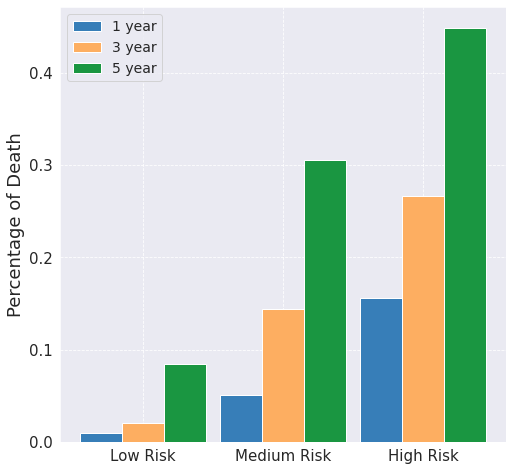

In [231]:
from matplotlib.ticker import FormatStrFormatter
plt.figure(figsize=[8,8])
colors_list_1_year = [ '#377eb8', '#377eb8','#377eb8']    #'#fdae61', '#d7191c',
colors_list_3_year = [ '#fdae61', '#fdae61','#fdae61']   #, '#fdae61', '#d7191c',
colors_list_5_year = [ '#1a9641', '#1a9641','#1a9641']
f, (ax) = plt.subplots(1, 1, figsize=[8,8])
labels = ['Low Risk', 'Medium Risk', 'High Risk']
barWidth = 0.3
br1 = np.arange(3)
ax.bar(br1, percentage_of_truth_DL_1_year, color =colors_list_1_year, width = barWidth, capsize=12,tick_label=labels)
#ax.set_yscale('log', basey=10) 
ax.grid(True,which="both", linestyle='--')

br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

ax.bar(br2, percentage_of_truth_DL_3_year, color =colors_list_3_year, width = barWidth, capsize=12,tick_label=labels)
ax.bar(br3, percentage_of_truth_DL_5_year, color =colors_list_5_year, width = barWidth, capsize=12)
#ax.set_yscale('log', basey=10) 
ax.grid(True,which="both", linestyle='--')
ax.set_ylabel('Percentage of Death', fontsize=18) #, labelpad=-550, fontsize=12)
#ax.set_xlabel('Risk Groups based on predicted probability for Resnet Model', fontsize=18)
#         plt.tick_params(axis='y', which='both', labelleft=False, labelright=True)
ax.tick_params(axis='y', which='minor', labelsize=8)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
ax.legend(['1 year', '3 year','5 year'],prop={'size': 14})
#ax.yaxis.set_minor_formatter(FormatStrFormatter("%.01d"))

plt.savefig('Death_percent_DL.png',pad_inches=0,bbox_inches = "tight")

<Figure size 576x576 with 0 Axes>

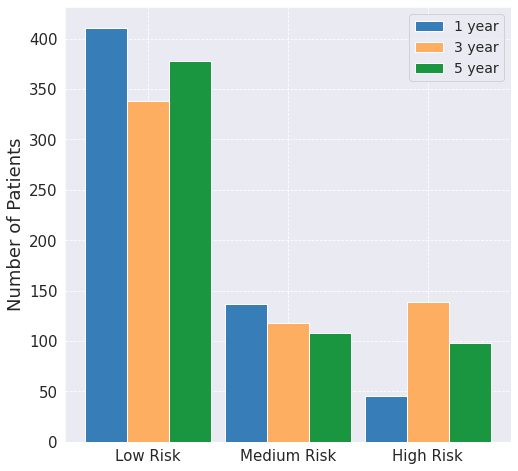

In [232]:
from matplotlib.ticker import FormatStrFormatter
plt.figure(figsize=[8,8])
colors_list_1_year = [ '#377eb8', '#377eb8','#377eb8']    #'#fdae61', '#d7191c',
colors_list_3_year = [ '#fdae61', '#fdae61','#fdae61']   #, '#fdae61', '#d7191c',
colors_list_5_year = [ '#1a9641', '#1a9641','#1a9641']
f, (ax) = plt.subplots(1, 1, figsize=[8,8])
#labels = ['[0, 0.33] \n Low Risk', '(0.33, 0.66] \n Medium Risk', '(0.66, 1] \n High Risk']
labels = ['Low Risk', 'Medium Risk', 'High Risk']
barWidth = 0.3
br1 = np.arange(3)
ax.bar(br1, number_of_encounters_DL_1_year, color =colors_list_1_year, width = barWidth, capsize=12,tick_label=labels)
#ax.set_yscale('log', basey=10) 
ax.grid(True,which="both", linestyle='--')

br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
ax.bar(br2, number_of_encounters_DL_3_year, color =colors_list_3_year, width = barWidth, capsize=12,tick_label=labels)
ax.bar(br3, number_of_encounters_DL_5_year, color =colors_list_5_year, width = barWidth, capsize=12)
#ax.set_yscale('log', basey=10) 
ax.grid(True,which="both", linestyle='--')
ax.set_ylabel('Number of Patients', fontsize=18) #, labelpad=-550, fontsize=12)
#ax.set_xlabel('Risk Groups based on predicted probability for Resnet Model', fontsize=18)
#         plt.tick_params(axis='y', which='both', labelleft=False, labelright=True)
ax.tick_params(axis='y', which='minor', labelsize=8)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
ax.legend(['1 year', '3 year','5 year'],prop={'size': 14})
plt.savefig('patient_no_DL.png',pad_inches=0,bbox_inches = "tight")

<Figure size 576x576 with 0 Axes>

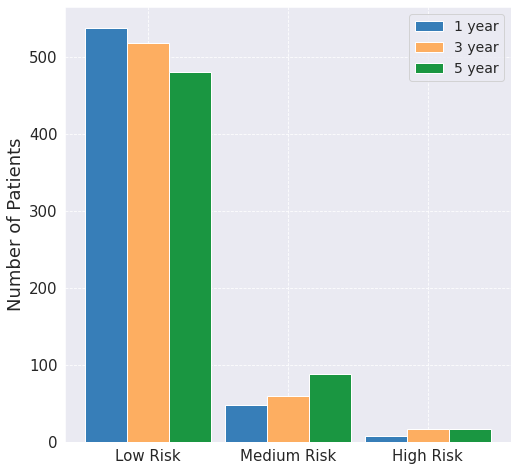

In [233]:
from matplotlib.ticker import FormatStrFormatter
plt.figure(figsize=[8,8])
colors_list_1_year = [ '#377eb8', '#377eb8','#377eb8']    #'#fdae61', '#d7191c',
colors_list_3_year = [ '#fdae61', '#fdae61','#fdae61']   #, '#fdae61', '#d7191c',
colors_list_5_year = [ '#1a9641', '#1a9641','#1a9641']
f, (ax) = plt.subplots(1, 1, figsize=[8,8])
#labels = ['[0, 0.33] \n Low Risk', '(0.33, 0.66] \n Medium Risk', '(0.66, 1] \n High Risk']
labels = ['Low Risk', 'Medium Risk', 'High Risk']
barWidth = 0.3
br1 = np.arange(3)
ax.bar(br1, number_of_encounters_Cat_1_year, color =colors_list_1_year, width = barWidth, capsize=12,tick_label=labels)
#ax.set_yscale('log', basey=10) 
ax.grid(True,which="both", linestyle='--')

br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
ax.bar(br2, number_of_encounters_Cat_3_year, color =colors_list_3_year, width = barWidth, capsize=12,tick_label=labels)
ax.bar(br3, number_of_encounters_Cat_5_year, color =colors_list_5_year, width = barWidth, capsize=12)
#ax.set_yscale('log', basey=10) 
ax.grid(True,which="both", linestyle='--')
ax.set_ylabel('Number of Patients', fontsize=18) #, labelpad=-550, fontsize=12)
#ax.set_xlabel('Risk Groups based on predicted probability for CatBoost Model', fontsize=18)
#         plt.tick_params(axis='y', which='both', labelleft=False, labelright=True)
ax.tick_params(axis='y', which='minor', labelsize=8)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
ax.legend(['1 year', '3 year','5 year'],prop={'size': 14})
plt.savefig('patient_no_Cat.png',pad_inches=0,bbox_inches = "tight")

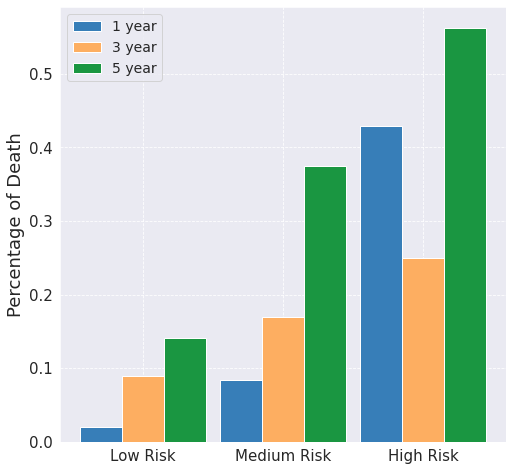

In [234]:
from matplotlib.ticker import FormatStrFormatter
colors_list_1_year = [ '#377eb8', '#377eb8','#377eb8']    #'#fdae61', '#d7191c',
colors_list_3_year = [ '#fdae61', '#fdae61','#fdae61']   #, '#fdae61', '#d7191c',
colors_list_5_year = [ '#1a9641', '#1a9641','#1a9641']
f, (ax) = plt.subplots(1, 1, figsize=[8,8])
#labels = ['[0, 0.33] \n Low Risk', '(0.33, 0.66] \n Medium Risk', '(0.66, 1] \n High Risk']
labels = ['Low Risk', 'Medium Risk', 'High Risk']
barWidth = 0.3
br1 = np.arange(3)
ax.bar(br1, percentage_of_truth_Cat_1_year, color =colors_list_1_year, width = barWidth, capsize=12,tick_label=labels)
#ax.set_yscale('log', basey=10) 
ax.grid(True,which="both", linestyle='--')

br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
ax.bar(br2, percentage_of_truth_Cat_3_year, color =colors_list_3_year, width = barWidth, capsize=12,tick_label=labels)
ax.bar(br3, percentage_of_truth_Cat_5_year, color =colors_list_5_year, width = barWidth, capsize=12)
#ax.set_yscale('log', basey=10) 
ax.grid(True,which="both", linestyle='--')
ax.set_ylabel('Percentage of Death', fontsize=18) #, labelpad=-550, fontsize=12)
#ax.set_xlabel('Risk Groups based on predicted probability for CatBoost Model', fontsize=18)
#         plt.tick_params(axis='y', which='both', labelleft=False, labelright=True)
ax.tick_params(axis='y', which='minor', labelsize=8)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
ax.legend(['1 year', '3 year','5 year'],prop={'size': 14})
plt.savefig('Death_percent_Cat.png',pad_inches=0,bbox_inches = "tight")

# 5 Fold AUROC Bar Plots

In [277]:
one_year_DL = [0.88,0.84,0.86,0.84,0.86]
one_year_Cat = [0.85,0.85,0.85,0.85,0.85]

one_year_external_DL = [0.82]
one_year_external_Cat = [0.78]
one_year_external_magic = [0.82]

three_year_DL = [0.90,0.89,0.90,0.89,0.87]
three_year_Cat = [0.88,0.88,0.88,0.88,0.88]
three_year_external_DL = [0.82]
three_year_external_Cat = [0.73]
three_year_external_magic = [0.78]

five_year_DL = [0.90,0.91,0.91,0.91,0.92]
five_year_Cat = [0.92,0.92,0.91,0.92,0.92]
five_year_external_DL = [0.78]
five_year_external_Cat = [0.75]
five_year_external_magic = [0.79]

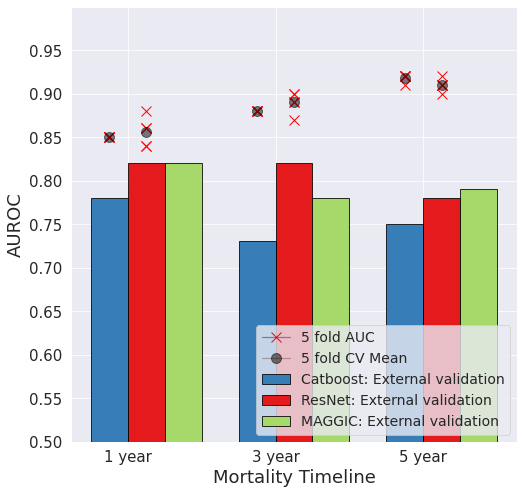

In [282]:
import numpy as np
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(8, 8))
sns.set_context('paper')
# set height of bar
DL = [np.array(one_year_DL).mean(),np.array(three_year_DL).mean(),np.array(five_year_DL).mean()]
Cat = [np.array(one_year_Cat).mean(),np.array(three_year_Cat).mean(),np.array(five_year_Cat).mean()]
Ext_DL = [np.array(one_year_external_DL).mean(),np.array(three_year_external_DL).mean(),np.array(five_year_external_DL).mean()]
Ext_Cat = [np.array(one_year_external_Cat).mean(),np.array(three_year_external_Cat).mean(),np.array(five_year_external_Cat).mean()]
Ext_magic = [np.array(one_year_external_magic).mean(),np.array(three_year_external_magic).mean(),np.array(five_year_external_magic).mean()]
# Set position of bar on X axis
#br1 = np.arange(len(DL))
#br2 = [x + barWidth for x in br1]
br3 = np.arange(len(DL))
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
mc1 = '#e41a1c'
mc2 = '#377eb8'
mc3 = '#a6d96a'
# Make the plot
#plt.bar(br1, DL,color = mc1, alpha = 0.85, width = barWidth,edgecolor ='black', label ='5 Fold ResNet Model',align='edge')
#plt.bar(br2, Cat, color =mc2, width = barWidth,edgecolor ='black', label ='5 Fold CatBoost Model',align='edge')
plt.bar(br3, Ext_Cat, color =mc2, width = barWidth,edgecolor ='black', label ='Catboost: External validation',align='edge')
plt.bar(br4, Ext_DL, color =mc1, width = barWidth,edgecolor ='black', label ='ResNet: External validation',align='edge')
plt.bar(br5, Ext_magic, color =mc3, width = barWidth,edgecolor ='black', label ='MAGGIC: External validation',align='edge')


distance = 0
for i in range(len(one_year_Cat)-1):
    plt.plot((barWidth-distance)/2, one_year_Cat[i], marker="x", markersize=10, markeredgecolor="red", markerfacecolor="green") 
plt.plot((barWidth-distance)/2, one_year_Cat[i], marker="x", markersize=10, markeredgecolor="red", markerfacecolor="green",label="5 fold AUC") 
#plt.plot(barWidth + (barWidth-distance)/2, one_year_external_Cat, marker="o", markersize=10, markeredgecolor="black", markerfacecolor="yellow")
plt.plot((barWidth-distance)/2, np.array(one_year_Cat).mean(), alpha = 0.50, marker="o", markersize=10, markeredgecolor="black", markerfacecolor="black",label="5 fold CV Mean")


for i in range(len(one_year_DL)):
    plt.plot(barWidth + (barWidth-distance)/2, one_year_DL[i], marker="x", markersize=10, markeredgecolor="red", markerfacecolor="green") 
plt.plot(barWidth + (barWidth-distance)/2, np.array(one_year_DL).mean(), alpha = 0.50, marker="o", markersize=10, markeredgecolor="black", markerfacecolor="black")


for i in range(len(three_year_Cat)):
    plt.plot(4*barWidth + (barWidth-distance)/2, three_year_Cat[i], marker="x", markersize=10, markeredgecolor="red", markerfacecolor="green") 
#plt.plot(3.5*barWidth + (barWidth-distance)/2, three_year_external_Cat, marker="o", markersize=10, markeredgecolor="black", markerfacecolor="yellow")
plt.plot(4*barWidth + (barWidth-distance)/2, np.array(three_year_Cat).mean(), alpha = 0.50, marker="o", markersize=10, markeredgecolor="black", markerfacecolor="black")

for i in range(len(three_year_DL)):
    plt.plot(5*barWidth + (barWidth-distance)/2, three_year_DL[i], marker="x", markersize=10, markeredgecolor="red", markerfacecolor="green") 
#plt.plot(2.5*barWidth + (barWidth-distance)/2, three_year_external_DL, marker="o", markersize=10, markeredgecolor="black", markerfacecolor="yellow")
plt.plot(5*barWidth + (barWidth-distance)/2, np.array(three_year_DL).mean(), alpha = 0.50, marker="o", markersize=10, markeredgecolor="black", markerfacecolor="black")

for i in range(len(five_year_Cat)):
    plt.plot(8*barWidth + (barWidth-distance)/2, five_year_Cat[i], marker="x", markersize=10, markeredgecolor="red", markerfacecolor="green") 
#plt.plot(6*barWidth + (barWidth-distance)/2, five_year_external_Cat, marker="o", markersize=10, markeredgecolor="black", markerfacecolor="yellow")
plt.plot(8*barWidth + (barWidth-distance)/2, np.array(five_year_Cat).mean(), alpha = 0.50, marker="o", markersize=10, markeredgecolor="black", markerfacecolor="black")

for i in range(len(five_year_DL)):
    plt.plot(9*barWidth + (barWidth-distance)/2, five_year_DL[i], marker="x", markersize=10, markeredgecolor="red", markerfacecolor="green") 
#plt.plot(5*barWidth + (barWidth-distance)/2, five_year_external_DL, marker="o", markersize=10, markeredgecolor="black", markerfacecolor="yellow")
plt.plot(9*barWidth + (barWidth-distance)/2, np.array(five_year_DL).mean(), alpha = 0.50, marker="o", markersize=10, markeredgecolor="black", markerfacecolor="black")



# Adding Xticks
plt.xlabel('Mortality Timeline', fontsize = 18)
plt.ylabel('AUROC', fontsize = 18)
plt.xticks([r + barWidth for r in range(len(DL))],
        ['1 year', '3 year', '5 year'],fontsize=15)
plt.yticks(np.arange(0, 1, 0.05),fontsize=15)
plt.legend(fontsize = 14,loc='lower right')
plt.ylim((0.5,1))
plt.savefig('Cat-DL_AUROC.png',pad_inches=0,bbox_inches = "tight")
plt.show()